In [105]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV

Text(0.5, 1.0, 'Jason-3 - Brouwer Mean Motion')

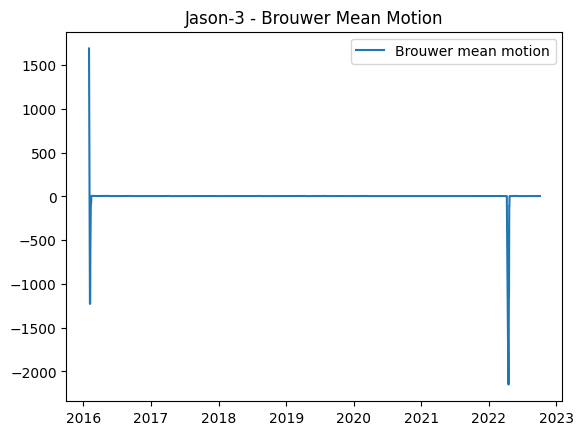

In [106]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_Jason-3.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Brouwer Mean Motion
df_bmm = df[["Brouwer mean motion"]]

# Centering and scaling the data
df_bmm = (df_bmm - df_bmm.mean()) * 1e7

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("Jason-3 - Brouwer Mean Motion")

In [107]:
start_date = pd.to_datetime("2017")
end_date = pd.to_datetime("2021")

# Filtering maneuvers based on the date range
df_bmm = df_bmm[df_bmm.index >= start_date]
df_bmm = df_bmm[df_bmm.index <= end_date]

df_bmm

,Brouwer mean motion
2017-01-01 13:15:37.146528,4.737564
2017-01-02 21:06:55.147680,4.766713
2017-01-03 21:28:30.085823,4.791497
2017-01-04 04:58:13.143648,4.793243
2017-01-05 05:19:48.074016,4.822393
...,...
2020-12-27 10:25:28.270271,5.270017
2020-12-28 07:02:11.613407,5.280828
2020-12-29 11:08:37.997087,5.284320
2020-12-30 11:30:12.862655,5.275587


In [108]:
NUM_LAG_FEATURES = 3

# Creating features and labels
df_bmm_y = df_bmm.copy()
df_bmm_x = df_bmm.shift(1)

# Renaming the 1st Lag feature
df_bmm_x = df_bmm_x.rename(columns={"Brouwer mean motion": "bmm_lag_1"})

# Adding the rest of the lag features based on the number of lags
for lag in range(2,NUM_LAG_FEATURES + 1):
    df_bmm_x[f"bmm_lag_{lag}"] = df_bmm.shift(lag)

In [109]:
df_bmm_x

,bmm_lag_1,bmm_lag_2,bmm_lag_3
2017-01-01 13:15:37.146528,NaN,NaN,NaN
2017-01-02 21:06:55.147680,4.737564,NaN,NaN
2017-01-03 21:28:30.085823,4.766713,4.737564,NaN
2017-01-04 04:58:13.143648,4.791497,4.766713,4.737564
2017-01-05 05:19:48.074016,4.793243,4.791497,4.766713
...,...,...,...
2020-12-27 10:25:28.270271,5.284862,5.291517,5.273179
2020-12-28 07:02:11.613407,5.270017,5.284862,5.291517
2020-12-29 11:08:37.997087,5.280828,5.270017,5.284862
2020-12-30 11:30:12.862655,5.284320,5.280828,5.270017


In [110]:
df_bmm_y

,Brouwer mean motion
2017-01-01 13:15:37.146528,4.737564
2017-01-02 21:06:55.147680,4.766713
2017-01-03 21:28:30.085823,4.791497
2017-01-04 04:58:13.143648,4.793243
2017-01-05 05:19:48.074016,4.822393
...,...
2020-12-27 10:25:28.270271,5.270017
2020-12-28 07:02:11.613407,5.280828
2020-12-29 11:08:37.997087,5.284320
2020-12-30 11:30:12.862655,5.275587


In [111]:
# Removing rows with NaN values
df_bmm_y = df_bmm_y.iloc[NUM_LAG_FEATURES:]
df_bmm_x = df_bmm_x.iloc[NUM_LAG_FEATURES:]

In [112]:
# Train Test data splitting based on date
SPLIT_DATE = "2019-10-25"
df_bmm_x_train = df_bmm_x[:SPLIT_DATE]
df_bmm_x_test = df_bmm_x[SPLIT_DATE:]
df_bmm_y_train = df_bmm_y[:SPLIT_DATE]
df_bmm_y_test = df_bmm_y[SPLIT_DATE:]

In [113]:
# Getting the training data percentage
train_percentage = df_bmm_y_train.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(train_percentage*100,2))

70.54


In [114]:
# Getting the testing data percentage
test_percentage = df_bmm_y_test.size / (df_bmm_y_train.size + df_bmm_y_test.size)
print(round(test_percentage*100,2))

29.46


In [115]:
# Using grid search to find the best hyperparameters
def grid_search_xgboost(X_train, y_train, cv = 5, verbose = 1):
    param_grid = {
        'n_estimators': [100,1000,1500,2000],
        'max_depth': [5,7,9],
        'learning_rate': [0.01,0.001,0.1],
        'colsample_bytree': [0.5,0.8,1],
        'min_child_weight': [3,5,7]
    }

    xgb_model = XGBRegressor(random_state = 25)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=cv,
        verbose=verbose,
        n_jobs=1
    )

    grid_search.fit(X_train,y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Best Parameters Found:")
    print(best_params)

    return best_model, best_params

best_xgb_model, best_xgb_params = grid_search_xgboost(df_bmm_x_train,df_bmm_y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters Found:
{'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 1000}


In [131]:
# Creating the XGBoost regressor with early stopping to avoid overfitting
xgb_regressor = XGBRegressor(
    n_estimators = 1000,
    max_depth = 5,
    learning_rate = 0.01,
    colsample_bytree = 1,
    min_child_weight = 7,
    subsample = 1,
    eval_metric = 'mae',
    early_stopping_rounds = 10
)

In [132]:
# Fitting the XGBoost model
xgb_regressor.fit(
    df_bmm_x_train,
    df_bmm_y_train,
    eval_set = [(df_bmm_x_train,df_bmm_y_train), (df_bmm_x_test,df_bmm_y_test)],
    verbose = True
)

[0]	validation_0-mae:0.28674	validation_1-mae:0.25040
[1]	validation_0-mae:0.28409	validation_1-mae:0.24807
[2]	validation_0-mae:0.28146	validation_1-mae:0.24575
[3]	validation_0-mae:0.27885	validation_1-mae:0.24345
[4]	validation_0-mae:0.27627	validation_1-mae:0.24119
[5]	validation_0-mae:0.27372	validation_1-mae:0.23894
[6]	validation_0-mae:0.27119	validation_1-mae:0.23672
[7]	validation_0-mae:0.26869	validation_1-mae:0.23452
[8]	validation_0-mae:0.26619	validation_1-mae:0.23238
[9]	validation_0-mae:0.26372	validation_1-mae:0.23026
[10]	validation_0-mae:0.26129	validation_1-mae:0.22813
[11]	validation_0-mae:0.25886	validation_1-mae:0.22605
[12]	validation_0-mae:0.25646	validation_1-mae:0.22399
[13]	validation_0-mae:0.25408	validation_1-mae:0.22196
[14]	validation_0-mae:0.25175	validation_1-mae:0.21991
[15]	validation_0-mae:0.24941	validation_1-mae:0.21791
[16]	validation_0-mae:0.24710	validation_1-mae:0.21594
[17]	validation_0-mae:0.24483	validation_1-mae:0.21395
[18]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=10, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

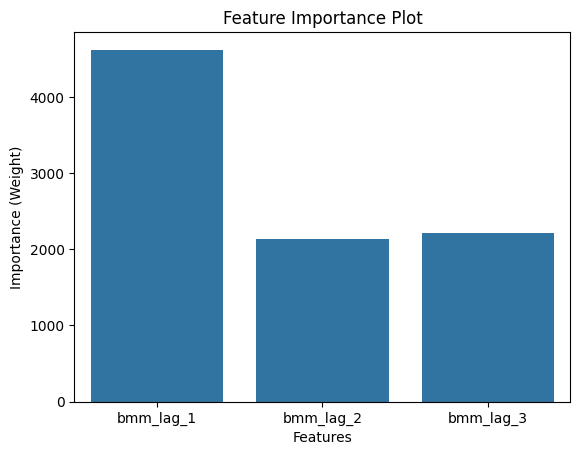

In [133]:
# Generating the feature importance plot
feature_importance = xgb_regressor.get_booster().get_score(importance_type = "weight")
sns.barplot(x = list(feature_importance.keys()), y = list(feature_importance.values()))
plt.xlabel("Features")
plt.ylabel("Importance (Weight)")
plt.title("Feature Importance Plot")
plt.show()

In [134]:
# Defining the format of the maneuver text file
columns_widths = [
    (0,5),      # Satellite Name
    (6,10),     # Begining of manueuver year    
    (11,14),    # Begining of manueuver day       
    (15,17),    # Begining of manueuver hour 
    (18,20),    # Begining of manueuver minute 
    (21,25),    # End of manueuver year 
    (26,29),    # End of manueuver day 
    (30,32),    # End of manueuver hour 
    (33,35),    # End of manueuver minute 
    (36,39),    # Manuever type
    (40,43),    # Manuever parameter type
    (44,45)     # Number of burns
]

# Function to parse each line based on column widths defined
def parse_line(line):
    data = [
        line[start:end].strip()
        for start, end in columns_widths
    ]
    return data

# Function to convert start and end maneuver to datetime
def convert_to_datetime(row):
    start_date = datetime.strptime(f"{row['Start_Year']} {row['Start_Day']} {row['Start_Hour']} {row['Start_Minute']}", "%Y %j %H %M")
    end_date = datetime.strptime(f"{row['End_Year']} {row['End_Day']} {row['End_Hour']} {row['End_Minute']}", "%Y %j %H %M")
    return start_date, end_date

# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/ja3man.txt'

# Reading the text file into a list of lines
with open(maneuver_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

# Parsing each line into a list of values
parsed_data = [parse_line(line) for line in lines]

# Defining the column names
column_names = [
    'Satellite', 'Start_Year', 'Start_Day', 'Start_Hour', 'Start_Minute',
    'End_Year', 'End_Day', 'End_Hour', 'End_Minute',
    'Maneuver_Type', 'Parameter_Type', 'Number_of_Burns'
]

# Creating a dataframe with the text file data
df = pd.DataFrame(parsed_data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'], df['End_Date'] = zip(*df.apply(convert_to_datetime,axis=1))

# Checking the dataframe
print(df.head())

  Satellite Start_Year Start_Day Start_Hour Start_Minute End_Year End_Day  \
0     JASO3       2016       019         22           18     2016     020   
1     JASO3       2016       021         22           39     2016     022   
2     JASO3       2016       028         22           45     2016     029   
3     JASO3       2016       031         21           38     2016     032   
4     JASO3       2016       033         03           35     2016     033   

  End_Hour End_Minute Maneuver_Type Parameter_Type Number_of_Burns  \
0       01         06                          007               2   
1       01         28                          007               2   
2       02         05                          007               2   
3       00         32                          007               2   
4       06         30                          007               2   

           Start_Date            End_Date  
0 2016-01-19 22:18:00 2016-01-20 01:06:00  
1 2016-01-21 22:39:00 2016-0

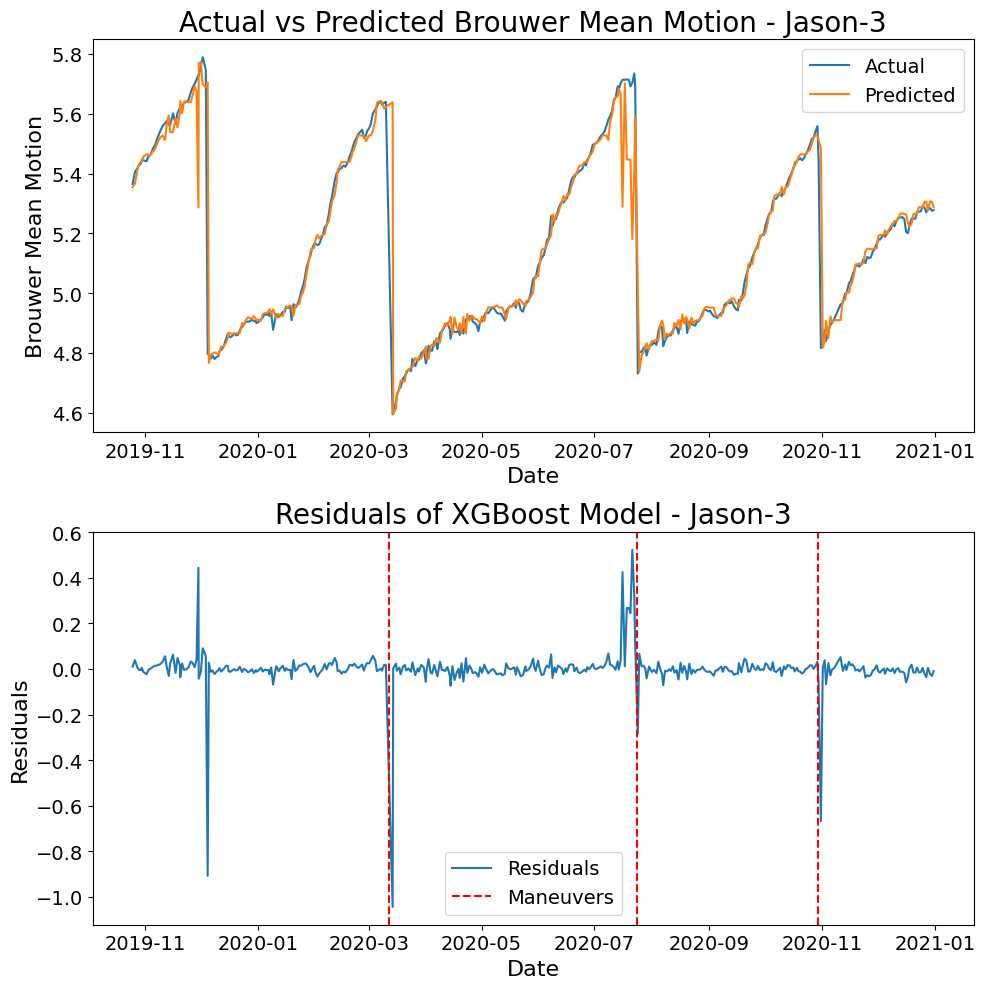

In [169]:
# Generating predictions
predictions = xgb_regressor.predict(df_bmm_x_test)

# Calculating residuals
residuals = df_bmm_y_test['Brouwer mean motion'].to_numpy() - predictions

# Creating a data frame for plotting
df_y_plotting = df_bmm_y_test.copy()
df_y_plotting["residuals"] = residuals
df_y_plotting["predictions"] = predictions

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (10,10))

# Plotting actual vs predicted values
sns.lineplot(x = df_bmm_y_test.index, y = df_bmm_y_test["Brouwer mean motion"], label = "Actual", ax = axes[0])
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["predictions"], label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Brouwer Mean Motion - Jason-3", fontsize=20)
axes[0].set_xlabel("Date",fontsize=16)
axes[0].set_ylabel("Brouwer Mean Motion",fontsize=16)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='both',labelsize=14)

# Plotting residuals
sns.lineplot(x = df_y_plotting.index, y = df_y_plotting["residuals"], label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of XGBoost Model - Jason-3", fontsize=20)
axes[1].set_xlabel("Date", fontsize=16)
axes[1].set_ylabel("Residuals", fontsize=16)
axes[1].tick_params(axis='both',labelsize=14)

start_date = pd.to_datetime("2020")
end_date = pd.to_datetime("2021-01")

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [137]:
df_y_plotting

,Brouwer mean motion,residuals,predictions
2019-10-25 06:01:27.029855,5.365029,0.010067,5.354962
2019-10-26 12:00:19.125503,5.404324,0.038853,5.365472
2019-10-27 19:51:36.967680,5.417423,0.005811,5.411612
2019-10-28 20:13:11.784000,5.428775,-0.004379,5.433153
2019-10-29 20:34:46.602048,5.433141,-0.005087,5.438227
...,...,...,...
2020-12-27 10:25:28.270271,5.270017,-0.035835,5.305851
2020-12-28 07:02:11.613407,5.280828,0.004914,5.275913
2020-12-29 11:08:37.997087,5.284320,-0.021891,5.306211
2020-12-30 11:30:12.862655,5.275587,-0.030264,5.305851


In [161]:
# Getting absolute values of the residuals for the anomaly statistic as a series
residuals_series = df_y_plotting["residuals"].sort_values().abs()
residuals_series = pd.Series(residuals_series, index = df_bmm.index)
residuals_series =residuals_series.dropna()
residuals_series

2019-10-25 06:01:27.029855    0.010067
2019-10-26 12:00:19.125503    0.038853
2019-10-27 19:51:36.967680    0.005811
2019-10-28 20:13:11.784000    0.004379
2019-10-29 20:34:46.602048    0.005087
                                ...   
2020-12-27 10:25:28.270271    0.035835
2020-12-28 07:02:11.613407    0.004914
2020-12-29 11:08:37.997087    0.021891
2020-12-30 11:30:12.862655    0.030264
2020-12-31 09:59:21.973919    0.009808
Name: residuals, Length: 426, dtype: float64

In [162]:
# Getting the maneuver time stamps into a series in date time format
maneuver_dates_series = pd.Series(pd.to_datetime(df.Start_Date))
maneuver_dates_series

0    2016-01-19 22:18:00
1    2016-01-21 22:39:00
2    2016-01-28 22:45:00
3    2016-01-31 21:38:00
4    2016-02-02 03:35:00
5    2016-02-03 20:53:00
6    2016-02-04 21:04:00
7    2016-02-07 22:35:00
8    2016-02-09 23:25:00
9    2016-02-11 22:19:00
10   2016-02-23 02:46:00
11   2016-04-04 01:49:00
12   2016-05-19 20:02:00
13   2016-07-25 02:50:00
14   2016-09-14 20:52:00
15   2016-12-22 21:13:00
16   2017-04-12 23:41:00
17   2017-09-06 16:34:00
18   2017-12-12 19:36:00
19   2018-04-04 00:21:00
20   2018-08-19 17:35:00
21   2018-12-18 17:59:00
22   2019-04-14 20:33:00
23   2019-06-16 19:47:00
24   2019-08-06 18:50:00
25   2019-12-03 15:26:00
26   2020-03-12 00:10:00
27   2020-07-23 21:24:00
28   2020-10-29 20:13:00
29   2021-02-04 00:43:00
30   2021-05-05 18:07:00
31   2021-07-22 15:51:00
32   2021-11-07 22:57:00
33   2022-02-15 21:20:00
34   2022-04-07 19:38:00
35   2022-04-11 20:15:00
36   2022-04-17 22:06:00
37   2022-04-19 21:03:00
38   2022-04-21 19:59:00
39   2022-04-24 19:13:00


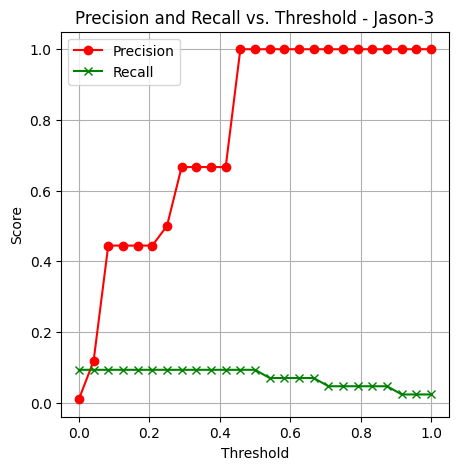

In [163]:
import pandas as pd
import numpy as np

def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def compute_simple_matching_precision_recall_for_one_threshold(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    """
    :param float_matching_max_days:
    :param float_threshold:
    :param pd_series_ground_truth_manoeuvre_timestamps:
    :param pd_series_predictions: The index of this series should be the timestamps of the predictions.
    :return: (precision, recall)

   Computes the precision and recall at one anomaly threshold.

   Does this using an implementation of the framework proposed by Zhao:
   Zhao, L. (2021). Event prediction in the big data era: A systematic survey. ACM Computing Surveys (CSUR), 54(5), 1-37.
   https://doi.org/10.1145/3450287

   The method matches each manoeuvre prediction with the closest ground-truth manoeuvre, if it is within a time window.

   Predictions with a match are then true positives and those without a match are false positives. Ground-truth manoeuvres
   with no matching prediction are counted as false negatives.
   """

    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()

    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0

    total_negatives = len(np_predictions) - len(pd_series_ground_truth_manoeuvre_timestamps)
    fpr = len(list_false_positives)/total_negatives

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall)/(precision + recall)

    return (precision, recall, fpr, f1_score)

# Create plot with precision and recall values for different thresholds
def plot_precision_recall_against_threshold_curve(threshold_range, precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, precisions, marker='o', label='Precision', color='red')
    plt.plot(threshold_range, recalls, marker='x', label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold - Jason-3')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculating precision and recall for multiple thresholds
def compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    precisions = []
    recalls = []
    fprs = []
    f1_scores = []

    for threshold in threshold_range:
        precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            threshold,
            pd_series_ground_truth_manoeuvre_timestamps,
            pd_series_predictions,
        )
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        f1_scores.append(f1_score)

    return precisions, recalls, fprs, f1_scores

if __name__ == "__main__":

    float_matching_max_days = 3
    threshold_range = np.linspace(0,1,25)

    precisions, recalls, fprs, f1_scores = compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    maneuver_dates_series,
    residuals_series,
    )

    plot_precision_recall_against_threshold_curve(threshold_range,precisions,recalls)

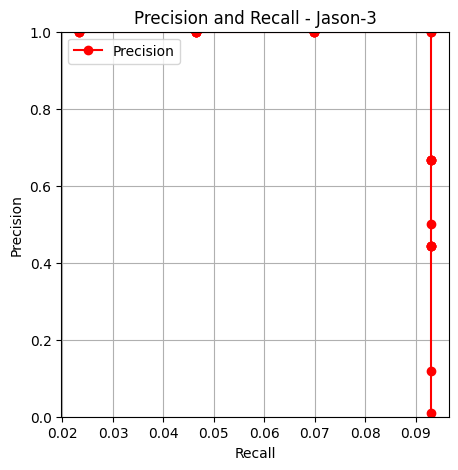

In [164]:
# Create plot with precision and recall
def plot_precision_recall_curve(precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(recalls, precisions, marker = 'o', label='Precision', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision and Recall - Jason-3')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(precisions, recalls)

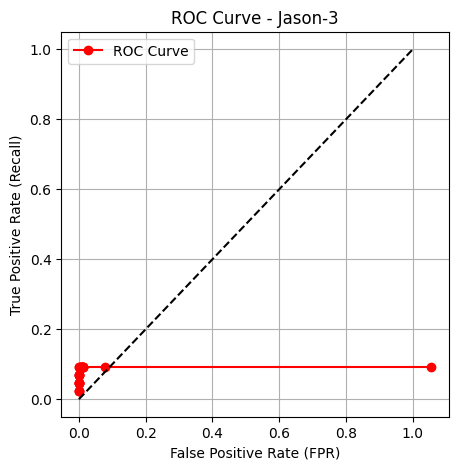

In [165]:
# Create roc plot
def plot_roc_curve(fprs, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(fprs, recalls, marker = 'o', label = 'ROC Curve', color='red')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve - Jason-3')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(fprs, recalls)

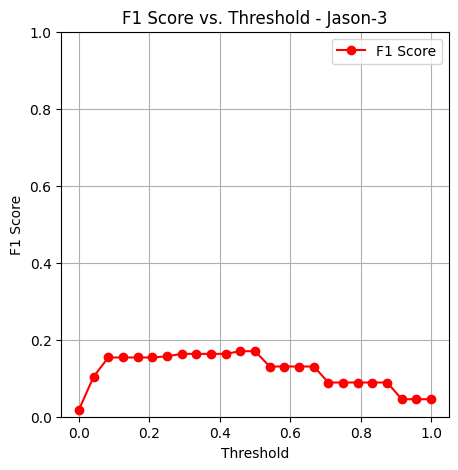

In [166]:
# Create f1_score vs threshold
def plot_f1_score_curve(threshold_range, f1_scores):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, f1_scores, marker = 'o', label = 'F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold - Jason-3')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_score_curve(threshold_range, f1_scores)

In [167]:
# Finding the max f1 score and the relevant threshold
max_index = np.argmax(f1_scores)
max_val = f1_scores[max_index]
max_val_threshold = threshold_range[max_index]

print(max_val)
print(max_val_threshold)

0.1702127659574468
0.4583333333333333


In [168]:
# Finding the precision and recall for max f1 score
precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            max_val_threshold,
            maneuver_dates_series,
            residuals_series,
        )

print(precision)
print(recall)

1.0
0.09302325581395349
